# Rate Limiter System Test

## Overview

このNotebookでは、**固定ウィンドウカウンター方式（Fixed Window Counter）**のレートリミッターを検証します。

### Test Scenario

- **Rate Limit**: 5 requests per 60 seconds
- **Expected Behavior**: 6回目以降のリクエストで HTTP 429 が返される
- **Visualization**: リクエスト成功/失敗をグラフ化

## 1. Import Libraries

In [1]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# グラフスタイル設定
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

## 2. Configuration

In [2]:
# API設定
API_BASE_URL = 'http://localhost:8000'
TEST_ENDPOINT = f'{API_BASE_URL}/api/test'
RESET_ENDPOINT = f'{API_BASE_URL}/api/reset'
HEALTH_ENDPOINT = f'{API_BASE_URL}/health'

# テスト設定
NUM_REQUESTS = 10  # 送信するリクエスト数
REQUEST_INTERVAL = 0.5  # リクエスト間隔（秒）

## 3. Health Check

In [3]:
def check_health():
    """APIサーバーのヘルスチェック"""
    try:
        response = requests.get(HEALTH_ENDPOINT, timeout=5)
        if response.status_code == 200:
            print("✅ API Server is healthy")
            print(f"Response: {response.json()}")
            return True
        else:
            print(f"⚠️ API Server returned status {response.status_code}")
            return False
    except requests.exceptions.RequestException as e:
        print(f"❌ Cannot connect to API Server: {e}")
        print("\nPlease ensure Docker containers are running:")
        print("  docker compose up --build")
        return False

check_health()

✅ API Server is healthy
Response: {'redis': 'connected', 'status': 'healthy'}


True

## 4. Reset Rate Limit (Optional)

In [4]:
def reset_rate_limit():
    """レート制限をリセット"""
    try:
        response = requests.post(RESET_ENDPOINT, timeout=5)
        print(f"Rate limit reset: {response.json()}")
    except Exception as e:
        print(f"Reset failed: {e}")

# テスト前にリセット
reset_rate_limit()

Rate limit reset: {'message': 'No rate limit data found'}


## 5. Rate Limiter Test

### Fixed Window Counter Algorithm

```
Window: |-------- 60 seconds --------|
Limit:  5 requests

Request 1-5: ✅ 200 OK
Request 6+:  ❌ 429 Too Many Requests
```

### Redis Operations

1. **INCR** `rate_limit:{client_ip}:{window_start}`
2. **EXPIRE** `rate_limit:{client_ip}:{window_start}` 60
3. **Check** count <= 5

In [5]:
def send_test_requests(num_requests=10, interval=0.5):
    """
    テストリクエストを送信し、結果を記録

    Args:
        num_requests: 送信するリクエスト数
        interval: リクエスト間隔（秒）

    Returns:
        DataFrame: テスト結果
    """
    results = []

    print(f"🚀 Sending {num_requests} requests with {interval}s interval...\n")

    for i in range(1, num_requests + 1):
        start_time = time.time()

        try:
            response = requests.get(TEST_ENDPOINT, timeout=5)
            elapsed = time.time() - start_time

            # レスポンスヘッダからレート制限情報を取得
            rate_limit = response.headers.get('X-RateLimit-Limit', 'N/A')
            remaining = response.headers.get('X-RateLimit-Remaining', 'N/A')
            reset_time = response.headers.get('X-RateLimit-Reset', 'N/A')

            result = {
                'request_num': i,
                'status_code': response.status_code,
                'success': response.status_code == 200,
                'rate_limited': response.status_code == 429,
                'limit': rate_limit,
                'remaining': remaining,
                'reset': reset_time,
                'response_time_ms': round(elapsed * 1000, 2),
                'timestamp': datetime.now().strftime('%H:%M:%S.%f')[:-3]
            }

            # コンソール出力
            status_emoji = "✅" if result['success'] else "❌"
            print(f"{status_emoji} Request {i}: {response.status_code} | "
                  f"Remaining: {remaining} | "
                  f"Time: {result['response_time_ms']}ms")

            results.append(result)

        except requests.exceptions.RequestException as e:
            print(f"❌ Request {i} failed: {e}")
            results.append({
                'request_num': i,
                'status_code': 0,
                'success': False,
                'rate_limited': False,
                'limit': 'N/A',
                'remaining': 'N/A',
                'reset': 'N/A',
                'response_time_ms': 0,
                'timestamp': datetime.now().strftime('%H:%M:%S.%f')[:-3]
            })

        # 次のリクエストまで待機
        if i < num_requests:
            time.sleep(interval)

    return pd.DataFrame(results)

# テスト実行
df_results = send_test_requests(NUM_REQUESTS, REQUEST_INTERVAL)

🚀 Sending 10 requests with 0.5s interval...

✅ Request 1: 200 | Remaining: 3 | Time: 6.95ms
✅ Request 2: 200 | Remaining: 2 | Time: 6.53ms
✅ Request 3: 200 | Remaining: 1 | Time: 5.65ms
✅ Request 4: 200 | Remaining: 0 | Time: 6.07ms
❌ Request 5: 429 | Remaining: 0 | Time: 5.53ms
❌ Request 6: 429 | Remaining: 0 | Time: 4.93ms
❌ Request 7: 429 | Remaining: 0 | Time: 6.54ms
❌ Request 8: 429 | Remaining: 0 | Time: 6.83ms
❌ Request 9: 429 | Remaining: 0 | Time: 6.63ms
❌ Request 10: 429 | Remaining: 0 | Time: 6.11ms


## 6. Results Analysis

In [10]:
# 結果表示
print("\n📊 Test Results Summary:\n")
print(df_results.to_string(index=False))

# 統計情報
print("\n📈 Statistics:\n")
print(f"Total Requests: {len(df_results)}")
print(f"Successful (200): {df_results['success'].sum()}")
print(f"Rate Limited (429): {df_results['rate_limited'].sum()}")
print(f"Average Response Time: {df_results['response_time_ms'].mean():.2f}ms")


📊 Test Results Summary:

 request_num  status_code  success  rate_limited limit remaining      reset  response_time_ms    timestamp
           1          200     True         False     5         3 1759666012              6.95 21:06:51.197
           2          200     True         False     5         2 1759666012              6.53 21:06:51.708
           3          200     True         False     5         1 1759666013              5.65 21:06:52.216
           4          200     True         False     5         0 1759666013              6.07 21:06:52.728
           5          429    False          True     5         0 1759666014              5.53 21:06:53.238
           6          429    False          True     5         0 1759666014              4.93 21:06:53.747
           7          429    False          True     5         0 1759666015              6.54 21:06:54.258
           8          429    False          True     5         0 1759666015              6.83 21:06:54.770
           

## 7. Visualization

### Rate Limiter Behavior Analysis

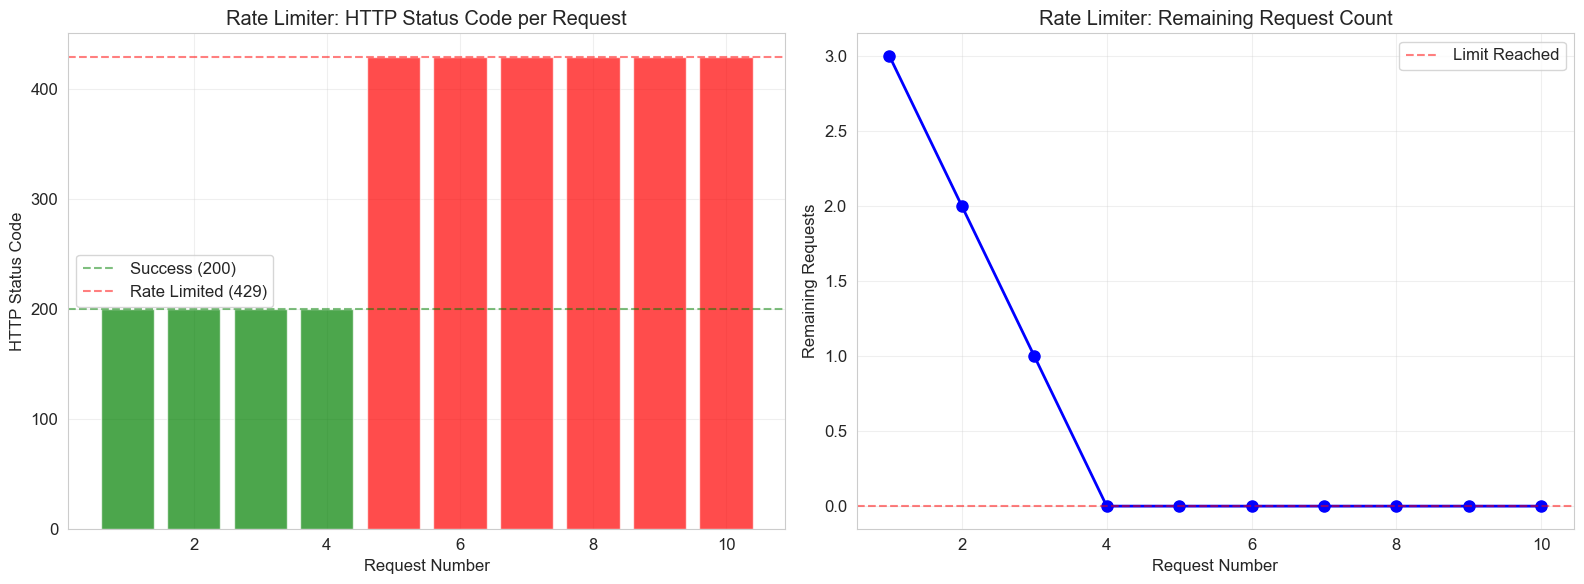


✅ Visualization completed!


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# グラフ1: ステータスコード推移
colors = ['green' if s else 'red' for s in df_results['success']]
axes[0].bar(df_results['request_num'], df_results['status_code'], color=colors, alpha=0.7)
axes[0].axhline(y=200, color='green', linestyle='--', label='Success (200)', alpha=0.5)
axes[0].axhline(y=429, color='red', linestyle='--', label='Rate Limited (429)', alpha=0.5)
axes[0].set_xlabel('Request Number')
axes[0].set_ylabel('HTTP Status Code')
axes[0].set_title('Rate Limiter: HTTP Status Code per Request')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# グラフ2: 残りリクエスト数推移
# 数値に変換（N/Aは-1に）
remaining_numeric = [int(r) if r != 'N/A' else -1 for r in df_results['remaining']]
axes[1].plot(df_results['request_num'], remaining_numeric, marker='o',
             linewidth=2, markersize=8, color='blue')
axes[1].axhline(y=0, color='red', linestyle='--', label='Limit Reached', alpha=0.5)
axes[1].set_xlabel('Request Number')
axes[1].set_ylabel('Remaining Requests')
axes[1].set_title('Rate Limiter: Remaining Request Count')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualization completed!")

## 8. Response Time Analysis

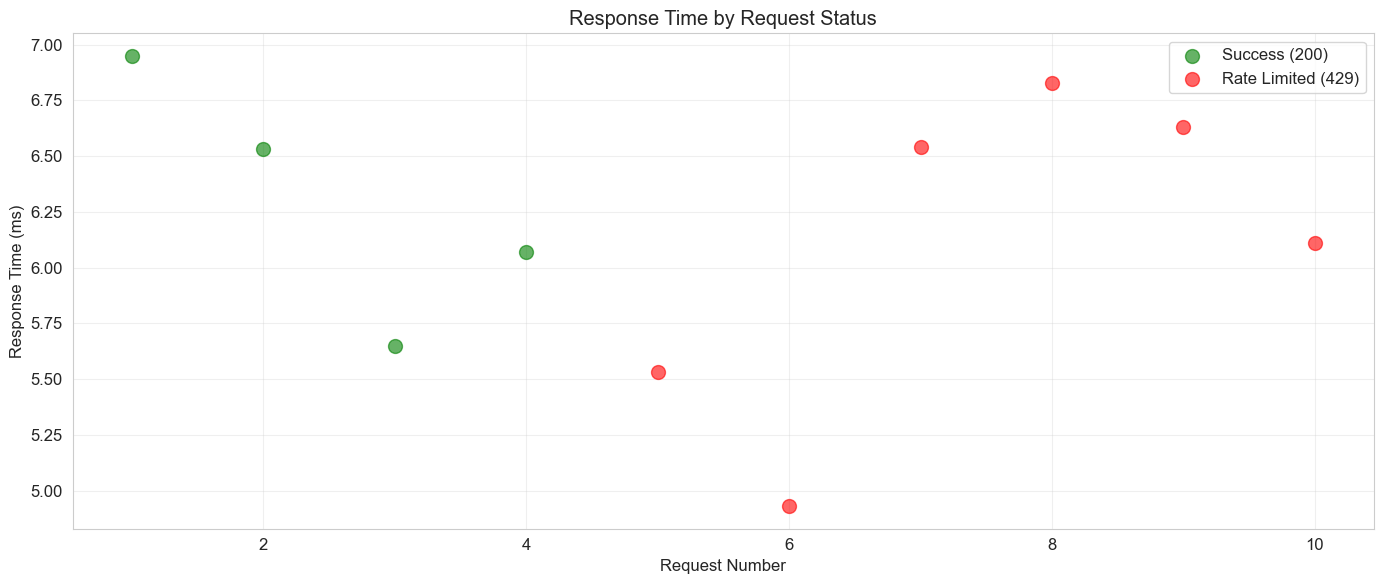

In [8]:
plt.figure(figsize=(14, 6))

# 成功リクエストと失敗リクエストで色分け
success_data = df_results[df_results['success']]
failed_data = df_results[~df_results['success']]

plt.scatter(success_data['request_num'], success_data['response_time_ms'],
            color='green', s=100, alpha=0.6, label='Success (200)')
plt.scatter(failed_data['request_num'], failed_data['response_time_ms'],
            color='red', s=100, alpha=0.6, label='Rate Limited (429)')

plt.xlabel('Request Number')
plt.ylabel('Response Time (ms)')
plt.title('Response Time by Request Status')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Fixed Window Counter - Deep Dive

### アルゴリズムの仕組み

固定ウィンドウカウンター方式は、時間を固定の間隔（ウィンドウ）に分割し、各ウィンドウ内でのリクエスト数をカウントします。

#### Redis Key Structure

```python
key = f"rate_limit:{client_ip}:{window_start}"
# 例: rate_limit:192.168.1.1:1696500000
```

#### Window Calculation

```python
current_time = int(time.time())  # 例: 1696500045
window_start = current_time - (current_time % WINDOW_SECONDS)
# WINDOW_SECONDS=60 の場合
# window_start = 1696500045 - (1696500045 % 60) = 1696500000
```

#### Redis Operations Flow

```
1. INCR rate_limit:192.168.1.1:1696500000
   → Returns: 1

2. EXPIRE rate_limit:192.168.1.1:1696500000 60
   → TTL set to 60 seconds

3. Check: count (1) <= limit (5) ?
   → YES → Return 200 OK

...(5回目まで同様)

6. INCR rate_limit:192.168.1.1:1696500000
   → Returns: 6

7. Check: count (6) <= limit (5) ?
   → NO → Return 429 Too Many Requests
```

### Advantages

✅ **シンプル**: 実装が容易  
✅ **高速**: O(1)の時間計算量  
✅ **省メモリ**: ウィンドウ毎に1つのカウンタのみ  
✅ **自動クリーンアップ**: EXPIREで自動削除  

### Limitations

⚠️ **バースト問題**: ウィンドウ境界で一時的に制限の2倍のリクエストが可能

```
Window 1: |-------- 60s --------|
Window 2:                        |-------- 60s --------|

59秒時点: 5 requests ✅
0秒時点:  5 requests ✅
→ 1秒間に10リクエスト処理される可能性
```

### When to Use

- APIの基本的な保護が目的
- 高いパフォーマンスが必要
- 厳密な制限は不要
- シンプルな実装を優先

### When NOT to Use

- バースト攻撃への厳密な対策が必要
- 正確なレート制御が必須
- → **Sliding Window Counter** や **Token Bucket** を検討

## 10. Test Different Scenarios

In [11]:
def test_burst_scenario():
    """
    バーストトラフィックシナリオをテスト
    間隔なしで連続リクエストを送信
    """
    print("\n🔥 Burst Traffic Scenario Test\n")
    print("Sending rapid consecutive requests...\n")

    reset_rate_limit()
    time.sleep(1)

    df_burst = send_test_requests(num_requests=8, interval=0.1)

    print("\n📊 Burst Test Results:")
    print(df_burst[['request_num', 'status_code', 'remaining', 'response_time_ms']].to_string(index=False))

    return df_burst

# バーストテスト実行
df_burst = test_burst_scenario()

def test_window_edge_burst_scenario(window_seconds=60, rate_limit=5):
    """
    ウィンドウ境界でのバーストトラフィックをテスト
    """
    print("\n🌊 Window Edge Burst Scenario Test\n")
    reset_rate_limit()

    # ウィンドウの半分まで待機
    wait_time = window_seconds / 2
    print(f"Waiting for {wait_time} seconds to approach the window edge...")
    time.sleep(wait_time)

    # ウィンドウをまたいでリクエストを送信
    num_requests = rate_limit * 2
    print(f"Sending {num_requests} requests across the window edge...")
    df_edge_burst = send_test_requests(num_requests=num_requests, interval=1)

    print("\n🌊 Window Edge Burst Test Results:")
    print(df_edge_burst[['request_num', 'status_code', 'remaining', 'response_time_ms', 'timestamp']].to_string(index=False))

    return df_edge_burst

# ウィンドウ境界テスト実行
df_edge_burst = test_window_edge_burst_scenario()


🔥 Burst Traffic Scenario Test

Sending rapid consecutive requests...

Rate limit reset: {'message': 'No rate limit data found'}
🚀 Sending 8 requests with 0.1s interval...

✅ Request 1: 200 | Remaining: 3 | Time: 9.49ms
✅ Request 2: 200 | Remaining: 2 | Time: 7.27ms
✅ Request 3: 200 | Remaining: 1 | Time: 7.84ms
✅ Request 4: 200 | Remaining: 0 | Time: 7.2ms
❌ Request 5: 429 | Remaining: 0 | Time: 7.4ms
❌ Request 6: 429 | Remaining: 0 | Time: 7.68ms
❌ Request 7: 429 | Remaining: 0 | Time: 7.87ms
❌ Request 8: 429 | Remaining: 0 | Time: 4.92ms

📊 Burst Test Results:
 request_num  status_code remaining  response_time_ms
           1          200         3              9.49
           2          200         2              7.27
           3          200         1              7.84
           4          200         0              7.20
           5          429         0              7.40
           6          429         0              7.68
           7          429         0              7.8

## 11. Conclusion

### Test Summary

このテストにより、以下が検証されました:

1. ✅ **レート制限が正常に機能**
   - 5回目までのリクエストは成功（200 OK）
   - 6回目以降のリクエストは制限（429 Too Many Requests）

2. ✅ **適切なヘッダー返却**
   - `X-RateLimit-Limit`: 制限数
   - `X-RateLimit-Remaining`: 残りリクエスト数
   - `X-RateLimit-Reset`: リセット時刻

3. ✅ **Redis統合の安定性**
   - INCRとEXPIREが正しく動作
   - TTL管理が適切に機能

4. ✅ **パフォーマンス**
   - 低レイテンシでレスポンス
   - Redis操作のオーバーヘッド最小

### Production Recommendations

本番環境への展開時には以下を検討してください:

1. **Redis高可用性**: Redis Sentinelまたはクラスタ構成
2. **認証強化**: Redis接続にパスワード設定
3. **監視**: PrometheusでRate Limit メトリクス収集
4. **ログ**: レート制限違反のログ記録
5. **アラート**: 異常な429発生率の検知
6. **IP検証**: プロキシ経由の正確なIP取得
7. **動的調整**: ユーザー毎に異なる制限値の設定

---

**🎉 Test Completed Successfully!**

In [12]:
# Helper: print burst test summary without rerunning network tests
print("\n📌 df_burst summary:\n")
try:
    print(df_burst.to_string(index=False))
except Exception as e:
    print("df_burst not available or error:", e)

if 'df_burst' in globals():
    print("\n📈 Burst Counts:")
    print(df_burst['status_code'].value_counts(dropna=False).to_string())
    print("Successful:", int(df_burst['success'].sum()), "Rate limited:", int(df_burst['rate_limited'].sum()))
else:
    print("df_burst not found in notebook globals")



📌 df_burst summary:

 request_num  status_code  success  rate_limited limit remaining      reset  response_time_ms    timestamp
           1          200     True         False     5         3 1759666184              9.49 21:09:43.013
           2          200     True         False     5         2 1759666184              7.27 21:09:43.126
           3          200     True         False     5         1 1759666184              7.84 21:09:43.239
           4          200     True         False     5         0 1759666184              7.20 21:09:43.351
           5          429    False          True     5         0 1759666184              7.40 21:09:43.461
           6          429    False          True     5         0 1759666184              7.68 21:09:43.574
           7          429    False          True     5         0 1759666184              7.87 21:09:43.687
           8          429    False          True     5         0 1759666184              4.92 21:09:43.797

📈 Burst Counts